## Marketing Data - Predictive Modeling for Campaign Response

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings('ignore')

### Load the segmented data

In [2]:
df = pd.read_csv('segmented_marketing_data.csv')

In [3]:
# Define column groups
education_cols = ['education_2n Cycle', 'education_Basic', 'education_Graduation', 'education_Master', 'education_PhD']
marital_cols = ['marital_Divorced', 'marital_Married', 'marital_Single', 'marital_Together', 'marital_Widow']

# Add 'Education' column
df['Education'] = df[education_cols].idxmax(axis=1).str.replace('education_', '')

# Add 'Marital_Status' column
df['Marital_Status'] = df[marital_cols].idxmax(axis=1).str.replace('marital_', '')

print(df[['Education', 'Marital_Status']].head())  # Display the first few rows of the new columns

    Education Marital_Status
0  Graduation         Single
1  Graduation         Single
2  Graduation       Together
3  Graduation       Together
4         PhD        Married


In [4]:
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Preferred_Product,Campaign_Response_Rate,Recency_Score,Spending_Segment,Has_Children,Total_Children,Customer_Value,Customer_Segment,Education,Marital_Status
0,58138.0,0,0,58,635,88,546,172,88,88,...,Wines,0.166667,41,High Spender,0,0,76322.4,Segment_3,Graduation,Single
1,46344.0,1,1,38,11,1,6,2,1,6,...,Wines,0.000000,61,Low Spender,1,2,0.0,Segment_1,Graduation,Single
2,71613.0,0,0,26,426,49,127,111,21,42,...,Wines,0.000000,73,Medium Spender,0,0,0.0,Segment_2,Graduation,Together
3,26646.0,1,0,26,11,4,20,10,3,5,...,MeatProducts,0.000000,73,Low Spender,1,1,0.0,Segment_1,Graduation,Together
4,58293.0,1,0,94,173,43,118,46,27,15,...,Wines,0.000000,5,Low Spender,1,1,0.0,Segment_3,PhD,Married


### Prepare data for modeling

In [4]:
# Target variable: Response (whether the customer accepted the last campaign)
target = 'Response'

In [5]:
# Features to use in the model
numeric_features = [
    'Income', 'Age', 'Customer_Days', 'Recency',
    'Total_Spent', 'Total_Purchases', 'NumWebVisitsMonth',
    'Campaign_Response_Rate', 'Customer_Value'
]

categorical_features = [
    'Education', 'Marital_Status', 'Preferred_Channel', 
    'Preferred_Product', 'Customer_Segment'
]

In [6]:
# Drop rows with missing values in the target variable
df_model = df.dropna(subset=[target])

In [7]:
# Split data into features and target
X = df_model[numeric_features + categorical_features]
y = df_model[target]

In [8]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [10]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Model Building

In [11]:
# 1. Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

In [12]:
# 2. Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [13]:
# 3. Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [14]:
# Dictionary of pipelines for cross-validation
pipelines = {
    'Logistic Regression': log_reg_pipeline,
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline
}

In [15]:
# Cross-validation
cv_results = {}
for name, pipeline in pipelines.items():
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    cv_results[name] = cv_score
    print(f"{name} - ROC AUC: {cv_score.mean():.4f} (+/- {cv_score.std():.4f})")

Logistic Regression - ROC AUC: 0.9851 (+/- 0.0061)
Random Forest - ROC AUC: 0.9856 (+/- 0.0039)
Gradient Boosting - ROC AUC: 0.9833 (+/- 0.0072)


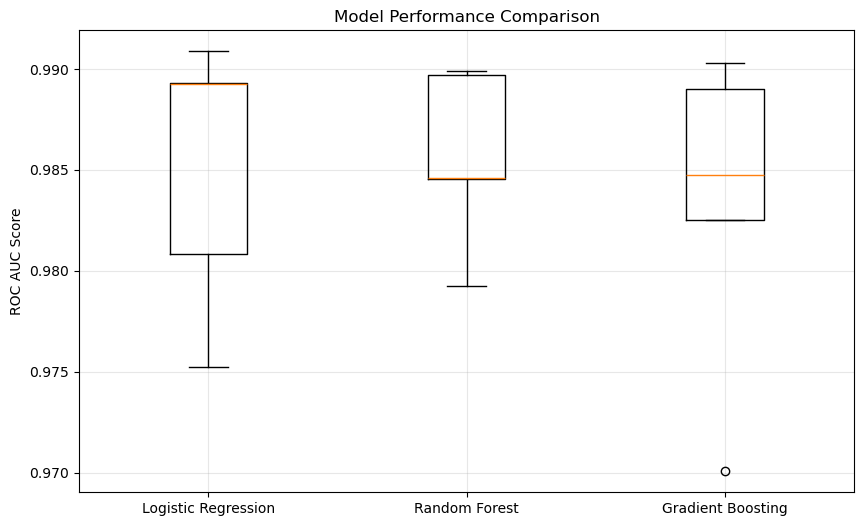

In [16]:
# Plot cross-validation results
plt.figure(figsize=(10, 6))
boxplot_data = [cv_results[name] for name in pipelines.keys()]
plt.boxplot(boxplot_data, labels=pipelines.keys())
plt.title('Model Performance Comparison')
plt.ylabel('ROC AUC Score')
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# Hyperparameter tuning for the best model
# Let's assume Random Forest performed best (adjust based on your results)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    rf_pipeline, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation score: 0.9861


In [18]:
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

### Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       374
           1       0.83      0.81      0.82        67

    accuracy                           0.95       441
   macro avg       0.90      0.89      0.89       441
weighted avg       0.94      0.95      0.95       441



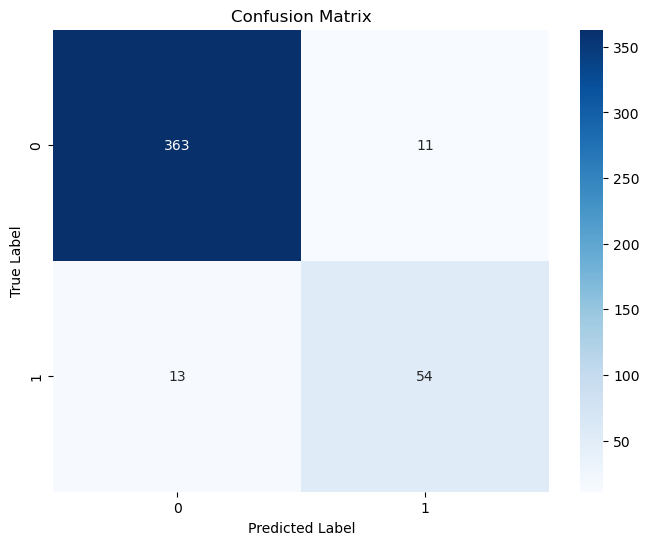

In [19]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

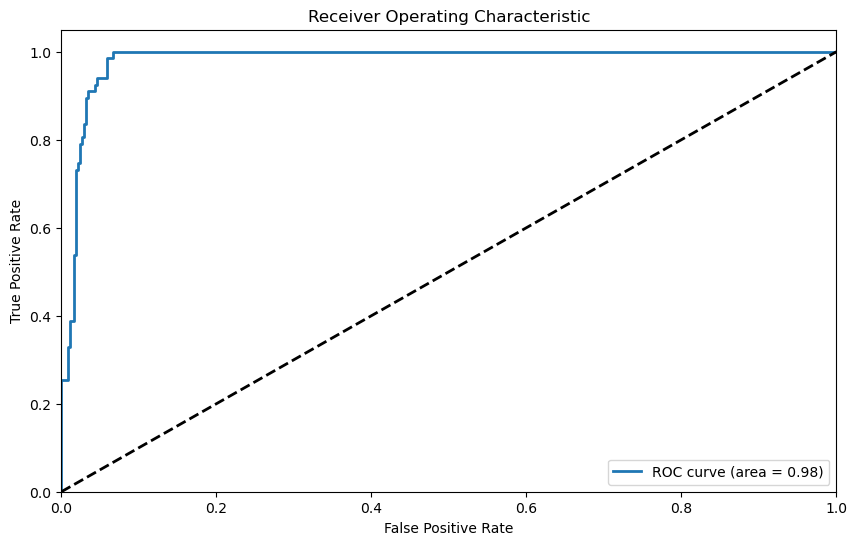

In [20]:
# ROC curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

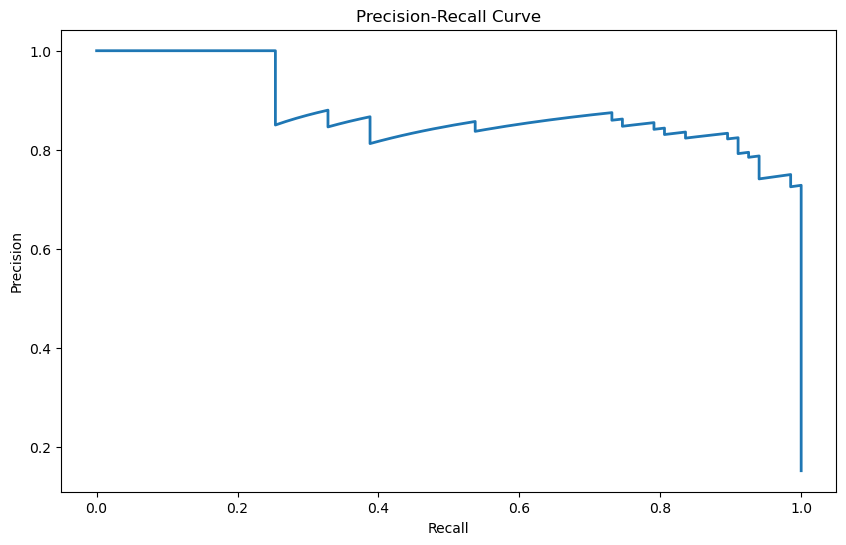

In [21]:
# Precision-Recall curve
plt.figure(figsize=(10, 6))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### Feature Importance Analysis

In [22]:
# Get feature names after preprocessing
preprocessor.fit(X_train)
feature_names = []

In [23]:
# Extract feature names from numeric features
feature_names.extend(numeric_features)

In [25]:
# Extract feature names from one-hot encoded categorical features
one_hot_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
feature_names.extend(one_hot_features)

In [26]:
# Permutation feature importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance = result.importances_mean

In [28]:
print("Feature Names Length:", len(feature_names))
print("Importance Length:", len(importance))

Feature Names Length: 33
Importance Length: 14


In [29]:
# Ensure equal lengths
min_length = min(len(feature_names), len(importance))
feature_names = feature_names[:min_length]
importance = importance[:min_length]

In [30]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names[:min_length],  # Ensuring both lists have the same length
    'Importance': importance[:min_length]
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

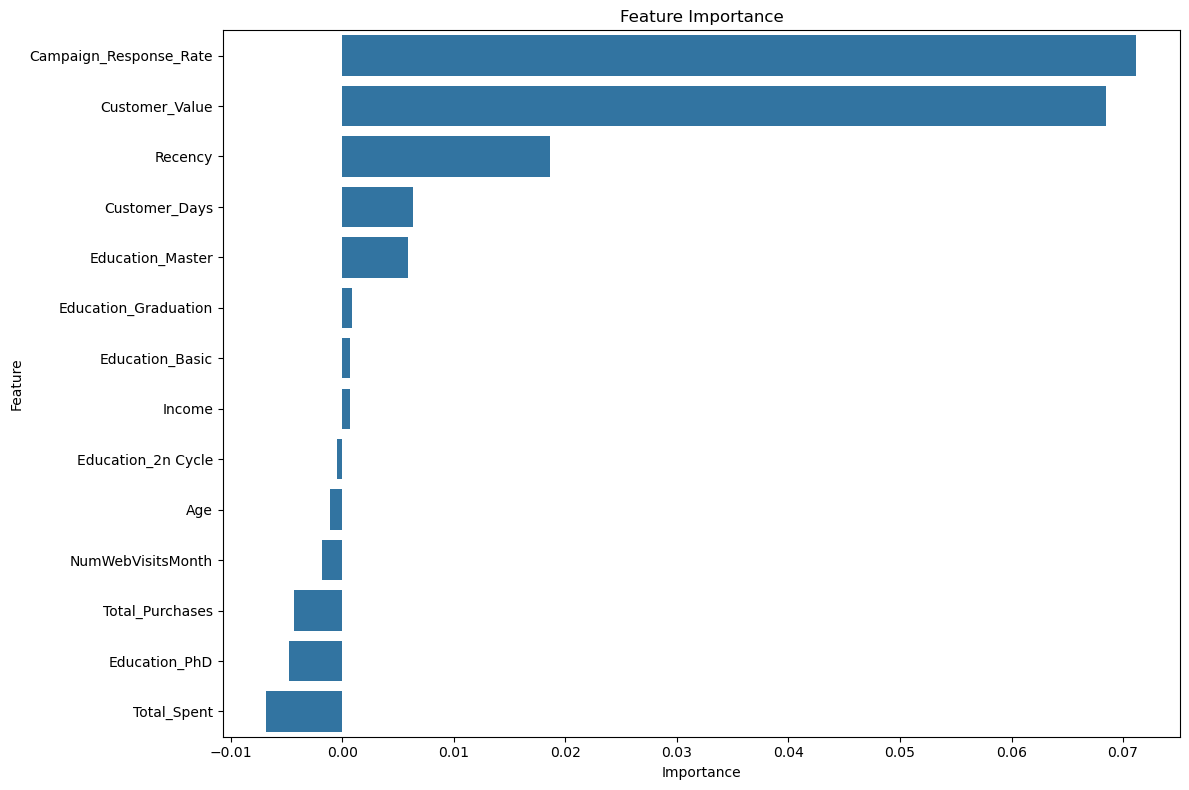

In [31]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [33]:
## Save the best model
joblib.dump(best_model, 'campaign_response_model.pkl')
print("Model saved to 'campaign_response_model.pkl'")

Model saved to 'campaign_response_model.pkl'


### Model Interpretation and Marketing Insights

In [34]:
# Identify key factors influencing campaign response
print("\nTop 5 factors influencing campaign response:")
for feature, importance in zip(feature_importance_df['Feature'].head(5), feature_importance_df['Importance'].head(5)):
    print(f"- {feature}: {importance:.4f}")


Top 5 factors influencing campaign response:
- Campaign_Response_Rate: 0.0712
- Customer_Value: 0.0685
- Recency: 0.0186
- Customer_Days: 0.0063
- Education_Master: 0.0059


In [35]:
# Calculate response rates by customer segment
segment_response = df.groupby('Customer_Segment')['Response'].mean().sort_values(ascending=False)
print("\nResponse rate by customer segment:")
display(segment_response)


Response rate by customer segment:


Customer_Segment
Segment_0    0.676329
Segment_3    0.141869
Segment_1    0.084646
Segment_2    0.061881
Name: Response, dtype: float64

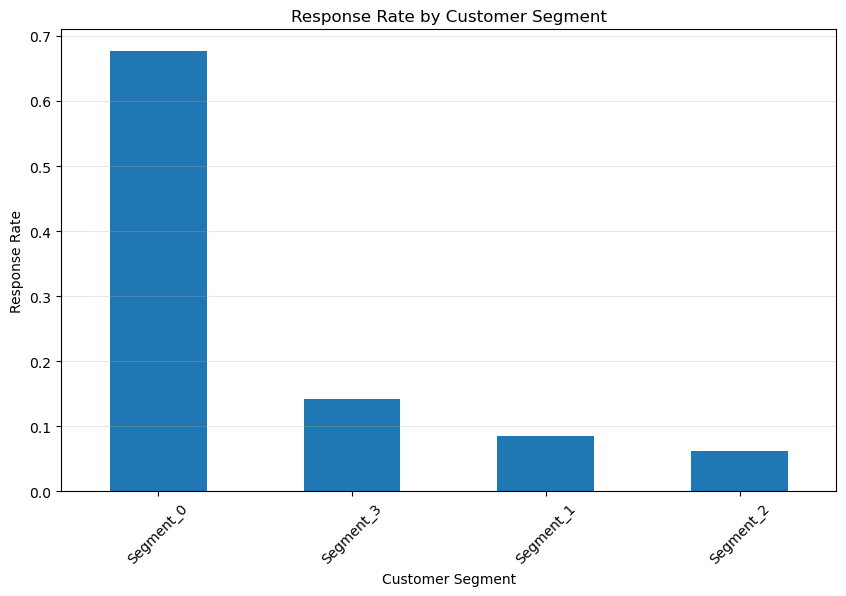

In [36]:
# Visualize response rate by customer segment
plt.figure(figsize=(10, 6))
segment_response.plot(kind='bar')
plt.title('Response Rate by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Response Rate')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

In [37]:
# Identify high-value customer segments for targeted marketing
high_value_segments = df.groupby('Customer_Segment')['Customer_Value'].mean().sort_values(ascending=False)
print("\nAverage customer value by segment:")
display(high_value_segments)


Average customer value by segment:


Customer_Segment
Segment_0    172041.931643
Segment_3     12632.976471
Segment_2     11769.064109
Segment_1       797.675410
Name: Customer_Value, dtype: float64

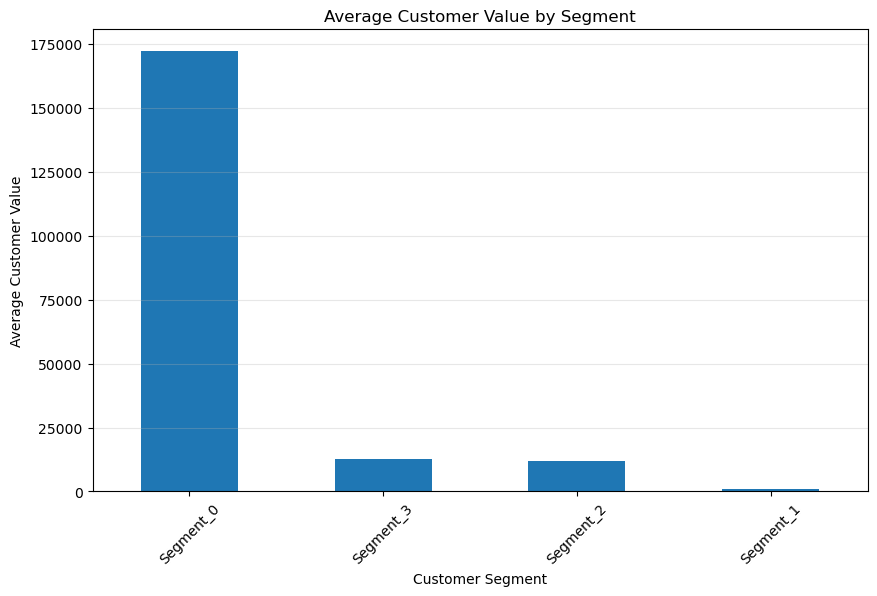

In [38]:
# Visualize customer value by segment
plt.figure(figsize=(10, 6))
high_value_segments.plot(kind='bar')
plt.title('Average Customer Value by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Customer Value')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

In [39]:
# Use model to predict response probabilities for all customers
df['Response_Probability'] = best_model.predict_proba(X)[:, 1]

In [40]:
# Identify high-probability responders who haven't responded yet
high_potential = df[(df['Response'] == 0) & (df['Response_Probability'] > 0.5)]
print(f"\nNumber of high-potential customers (non-responders with >50% response probability): {len(high_potential)}")


Number of high-potential customers (non-responders with >50% response probability): 12


In [41]:
# Save predictions back to the processed data
df.to_csv('marketing_data_with_predictions.csv', index=False)
print("Data with predictions saved to 'marketing_data_with_predictions.csv'")

Data with predictions saved to 'marketing_data_with_predictions.csv'


### Marketing Recommendations Based on Analysis

In [42]:
# Identify customer segments most likely to respond
print("\n=== Marketing Strategy Recommendations ===")
print("\n1. Target Customer Segments:")
segment_potential = df.groupby('Customer_Segment')['Response_Probability'].mean().sort_values(ascending=False)
for segment, prob in segment_potential.items():
    print(f"   - {segment}: Average response probability of {prob:.2%}")


=== Marketing Strategy Recommendations ===

1. Target Customer Segments:
   - Segment_0: Average response probability of 64.83%
   - Segment_3: Average response probability of 13.86%
   - Segment_1: Average response probability of 8.38%
   - Segment_2: Average response probability of 6.37%


In [43]:
# Identify preferred channels by high-response probability segments
high_resp_segments = segment_potential.index[:2]  # Top 2 segments
print("\n2. Preferred Channels by High-Response Segments:")
for segment in high_resp_segments:
    channel_dist = df[df['Customer_Segment'] == segment]['Preferred_Channel'].value_counts(normalize=True)
    print(f"   - {segment}:")
    for channel, pct in channel_dist.items():
        print(f"     * {channel}: {pct:.2%}")


2. Preferred Channels by High-Response Segments:
   - Segment_0:
     * Store: 57.49%
     * Catalog: 23.67%
     * Web: 18.84%
   - Segment_3:
     * Store: 48.10%
     * Web: 39.97%
     * Deals: 8.13%
     * Catalog: 3.81%


In [44]:
# Identify product preferences by high-response probability segments
print("\n3. Product Preferences by High-Response Segments:")
for segment in high_resp_segments:
    product_dist = df[df['Customer_Segment'] == segment]['Preferred_Product'].value_counts(normalize=True)
    print(f"   - {segment}:")
    for product, pct in product_dist.items():
        print(f"     * {product}: {pct:.2%}")


3. Product Preferences by High-Response Segments:
   - Segment_0:
     * Wines: 77.29%
     * MeatProducts: 22.71%
   - Segment_3:
     * Wines: 91.00%
     * MeatProducts: 6.75%
     * GoldProds: 1.21%
     * FishProducts: 0.87%
     * SweetProducts: 0.17%
